# Mohammed EL YAAGOUBI
# MDI341 Data Challenge: Large Scale Machine Learning



# Image Classification:

Image classification is the task of assigning to an image a label from a predefined set of
categories. A CNN [1] is intended to identify visual forms from images with least computation [2]. In the last few years, we saw a rapid progress in visual image processing systems, mostly due to advances of deep convolutional neural networks.



1. Y. LeCun, L. Bottu, Y. Bengio, Gradient-based learning applied to document recognition, Proceedings of the
IEEE 86 (11) (1998) 2278–2324, https://doi.org/10.1109/5.726791.
2. Alex Krizhevsky, Ilya Sutskever, Geoffrey E. Hinton, Imagenet classification with deep convolutional neural net-works, in: NIPS’12 Proceedings of the 25th InternationalConference on Neural Information ProcessingSystem,
vol. 1, 2012, pp. 1097–1105, arXiv:1311.2901.

### Downloading the Data: 

You can download the Dataset from the below link: 
https://partage.imt.fr/index.php/s/9nJkXPXMwH9MT83

After unzipping the file, you have three folders: train, validation, test and two text files relating to the train and validation labels. You can use both training and validation data for training and validation your model.


### Training and Validation Data

***Training Data:*** The "train" folder contains 149,943 face images numbered from 000000 to 149942. These are color images in .jpg format with size of 80x80 pixels.

***Training Labels:*** The file named "label_train.txt" contains two columns. The first column list the 149,943 labels (0 or 1) that are used to train your model. The second columns lists the corresponding binary representation of genders (0: woman, 1: Man)

***Validation Data:*** The "validation" folder contains 24,996 face images numbered from 000000 to 024995. These are color images in .jpg format with size of 80x80 pixels.

***Validation Labels:*** The file named "label_validation.txt" contains two columns. The first column list the 24,996 labels (0 or 1) that are used to validate your model. The second columns lists the corresponding binary representation of genders (0: woman, 1: Man)

### Test Data

 The "test" folder contains 27,596 face images numbered from 000000 to 027595. These are color images in .jpg format with size of 80x80 pixels.

 ### Remarks

 Image classification with certian unknown characteristics are difficult task. The purpose of this data challenge is to train the students to extract different characteristicts from images. So, it is important that at the end of the data challenge, you know the characteristics of the images on which this dataset is based on.

 ### The Performance Criterion:

You should submit a file that contains in each row classificaiton of images available in **test** folder. For a sample submission please see the codes below. 
To measure the performance of your model, we calculate two parameters.

1- Global Classification Error 

2- Absolute_value(Classification_Error_Men - Classification_Error_Women)

Using these two Errors, we calculate your Borda and Copeland scores which are the Ranking methods used in preferential voting. You can find the detail of these methods under the two links below.

https://en.wikipedia.org/wiki/Borda_count

https://en.wikipedia.org/wiki/Copeland%27s_method

Your final ranking is based on **Copeland score**.

For this data challenge I've made transfer learning and model ensembling (especially stacking). This notebook provides an overview of the different models trained and the final ensembling predictions. All models have been trained using PyTorch.

In [ ]:
import glob, os, re
import cv2 as cv
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
import torch.nn.functional as F
from facenet_pytorch import InceptionResnetV1, fixed_image_standardization

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Dataset and Dataloaders

### Data Preparation

In [ ]:
# Train
train_labels = pd.read_csv('label_train.txt', sep = ' ', header = None, names = ['label', 'genre'], dtype=int)
filenames = os.listdir('train')
filenames.sort(key=lambda f: int(re.sub('\D', '', f)))
train_filenames = pd.DataFrame(filenames, columns = ['filenames'])
train_df = pd.concat([train_filenames, train_labels], axis=1)

# Validation
val_labels = pd.read_csv('label_validation.txt', sep = ' ', header = None, names = ['label', 'genre'], dtype=int)
filenames = os.listdir('validation')
filenames.sort(key=lambda f: int(re.sub('\D', '', f)))
val_filenames = pd.DataFrame(filenames, columns = ['filenames'])
val_df = pd.concat([val_filenames, val_labels], axis=1)

# Test
filenames = os.listdir('test')
filenames.sort(key=lambda f: int(re.sub('\D', '', f)))
test_df = pd.DataFrame(filenames, columns = ['filenames'])

In [ ]:
BATCH_SIZE = 32

I created a custom dataset in pytorch in order to be able to load the images in the dataframes, as well as the label and the genre.

In [ ]:
class IdemiaDataset(Dataset):
    """Idemia dataset."""

    def __init__(self, dataframe, root_dir, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): dataframe with labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        if 'test' in self.root_dir:
            label=-1
            gender=-1
        else:
            label = float(self.dataframe.iloc[idx, 1])
            gender = float(self.dataframe.iloc[idx, 2])

        if self.transform:
            image = self.transform(image)

        return (image,label,gender)

These are the dataloaders and augmentations used for training the models. Using heavy augmentations help a lot to reduce overfitting, and thus to train models for longer. For data augmentations I used:
* resizing: I trained differents models with different image size. It's better to have more diversity for stacking.
* random horizontal flipping
* random rotation (-30,30)
* random translation (10% vertical, 10% horizontal)
* random scaling (0.9,1.1)
* random brightness, contrast, saturation, hue (20%)
* random perspective (20%)
* random erasing: erase some portion of images which force the model to learn more robust features
* normalization

In [ ]:
train_transformations = transforms.Compose([transforms.Resize(size=160),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomAffine(degrees=30, translate=(0.1,0.1), scale=(.9, 1.1)),
                                     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue = 0.2),
                                     transforms.RandomPerspective(distortion_scale=0.2),
                                     np.float32,
                                     transforms.ToTensor(),
                                     transforms.RandomErasing(scale=(0.02, 0.16), ratio=(0.3, 1.6)),
                                     fixed_image_standardization
])
val_transformations = transforms.Compose([transforms.Resize(size=160),
                                     np.float32,
                                     transforms.ToTensor(),
                                     fixed_image_standardization
])
train_dataset = IdemiaDataset(dataframe=train_df, root_dir='train/', transform=train_transformations)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=4)

val_dataset = IdemiaDataset(dataframe=val_df, root_dir='validation/', transform=val_transformations)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4)

test_dataset = IdemiaDataset(dataframe=test_df, root_dir='test/', transform=val_transformations)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


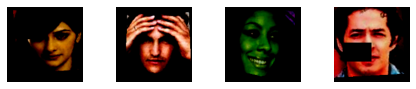

In [ ]:
fig = plt.figure()

for i_batch, (imgs,labels,genders) in enumerate(train_loader):
    for i in range(4):
        ax = plt.subplot(1, 4, i + 1)
        plt.tight_layout()
        ax.axis('off')
        plt.imshow(imgs[i].permute(1,2,0))
    break

# Models trained

I have trained 8 models with differents architectures, differents images sizes, differents loss functions and differents pretrained weights.
I used two loss functions:
* Binary Cross Entropy (BCE)
* Focal loss : It is a variant of the BCE, which give more weight to misclassified exemples and less weight to correclty classified exemples. The gamma parameter controls the "importance" given to misclassified exemples. I found it useful for our task, to reduce the bias between men and women, because models make more errors on men. So we force models to focus on men misclassified exemples.

![image.png](attachment:image.png)

And I used 4 differents architectures. My first idea was to do transfer learning. I tried to finetune a model trained on imagenet. However results were not much better than a model trained from scratch. So features learnt on imagenet are not suitable for our task. Therefore I searched for models pretrained on well-known face datasets such as vggface, casia-Webface etc. I found two pretrained models:
* facenet(https://github.com/timesler/facenet-pytorch): IncepetionResnet model trained on either vggface or casia.
* Senet50 (https://www.robots.ox.ac.uk/~albanie/pytorch-models.html) trained on vggface2.

I downloaded the architectures and pretrained weights and finetuned these models with a really small learning rate. This transfer learning has already allowed me to obtain very good results as we will see below.
I also used two architectures trained from scratch:
* vgg-19 with batchnorm
* resnet_50

Below is a summary of the model trained with their performances. It was important to trained models with differents parameters to get more diversity (it does not make sense to stack models that have all learn the same things).

| Architecture | Criterion | Pretrained | Image size | Classification error | Gender error |
| --- | --- | --- |  --- | --- | --- |
| Senet50 | bce | vggface2 | 224x224 | 0.182 | 0.061 |
| Senet50 | focal-5 | vggface2 | 224x224 | 0.185 | 0.062 |
| InceptionResnet | bce | vggface | 160x160 | 0.178 | 0.057 |
| InceptionResnet | focal-2 | vggface | 160x160 | 0.181 | 0.059 |
| InceptionResnet | focal-2 | casia | 160x160 | 0.187 | 0.071 |
| InceptionResnet | focal-4 | vggface | 160x160 | 0.181 | 0.066 |
| vgg_bn_19 | bce | scratch | 80x80 | 0.197 | 0.082 |
| resnet50 | bce | scratch | 160x160 | 0.198 | 0.084 |

Also, to give equal weights to both gender during training I compute the loss as the mean of the loss for gender 0 and the loss for gender 1:
```python
loss0 = criterion(outputs[mask_gender0], labels[mask_gender0])
loss1 = criterion(outputs[mask_gender1], labels[mask_gender1])
loss = 0.5*loss0 + 0.5*loss1
loss.backward()
```
It helps reduce bias between men and women. In addition during training I saved the model which have the best mean accuracy between gender 0 and gender 1, ie:

```python
score = np.mean([accuracy_gender0, accuracy_gender1])
if score > best_score:
    best_score = score
    torch.save(model.state_dict(), save_path)
    print("Best model saved!")
```

## The following section is just the predictions of each model for the validation and test set. You can directly go to the ensembling section.

In [ ]:
sigmoid = nn.Sigmoid()

## 224x224 dataloader

In [ ]:
val_transformations = transforms.Compose([transforms.Resize(size=224),
                                     transforms.ToTensor(),
                                     lambda x: x * 255.0,
                                     transforms.Normalize([131.0912, 103.8827, 91.4953], [1, 1, 1])
])

val_dataset = IdemiaDataset(dataframe=val_df, root_dir='validation/', transform=val_transformations)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4)

test_dataset = IdemiaDataset(dataframe=test_df, root_dir='test/', transform=val_transformations)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4)

### Senet50

In [ ]:
class Senet50_ft_dag(nn.Module):

    def __init__(self):
        super(Senet50_ft_dag, self).__init__()
        self.meta = {'mean': [131.0912, 103.8827, 91.4953],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_7x7_s2 = nn.Conv2d(3, 64, kernel_size=[7, 7], stride=(2, 2), padding=(3, 3), bias=False)
        self.conv1_7x7_s2_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv1_relu_7x7_s2 = nn.ReLU()
        self.pool1_3x3_s2 = nn.MaxPool2d(kernel_size=[3, 3], stride=[2, 2], padding=(0, 0), dilation=1, ceil_mode=True)
        self.conv2_1_1x1_reduce = nn.Conv2d(64, 64, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv2_1_1x1_reduce_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_1_1x1_reduce_relu = nn.ReLU()
        self.conv2_1_3x3 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv2_1_3x3_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_1_3x3_relu = nn.ReLU()
        self.conv2_1_1x1_increase = nn.Conv2d(64, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv2_1_1x1_increase_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_1_global_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv2_1_1x1_down = nn.Conv2d(256, 16, kernel_size=[1, 1], stride=(1, 1))
        self.conv2_1_1x1_down_relu = nn.ReLU()
        self.conv2_1_1x1_up = nn.Conv2d(16, 256, kernel_size=[1, 1], stride=(1, 1))
        self.conv2_1_prob = nn.Sigmoid()
        self.conv2_1_1x1_proj = nn.Conv2d(64, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv2_1_1x1_proj_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_1_relu = nn.ReLU()
        self.conv2_2_1x1_reduce = nn.Conv2d(256, 64, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv2_2_1x1_reduce_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_2_1x1_reduce_relu = nn.ReLU()
        self.conv2_2_3x3 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv2_2_3x3_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_2_3x3_relu = nn.ReLU()
        self.conv2_2_1x1_increase = nn.Conv2d(64, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv2_2_1x1_increase_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_2_global_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv2_2_1x1_down = nn.Conv2d(256, 16, kernel_size=[1, 1], stride=(1, 1))
        self.conv2_2_1x1_down_relu = nn.ReLU()
        self.conv2_2_1x1_up = nn.Conv2d(16, 256, kernel_size=[1, 1], stride=(1, 1))
        self.conv2_2_prob = nn.Sigmoid()
        self.conv2_2_relu = nn.ReLU()
        self.conv2_3_1x1_reduce = nn.Conv2d(256, 64, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv2_3_1x1_reduce_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_3_1x1_reduce_relu = nn.ReLU()
        self.conv2_3_3x3 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv2_3_3x3_bn = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_3_3x3_relu = nn.ReLU()
        self.conv2_3_1x1_increase = nn.Conv2d(64, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv2_3_1x1_increase_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_3_global_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv2_3_1x1_down = nn.Conv2d(256, 16, kernel_size=[1, 1], stride=(1, 1))
        self.conv2_3_1x1_down_relu = nn.ReLU()
        self.conv2_3_1x1_up = nn.Conv2d(16, 256, kernel_size=[1, 1], stride=(1, 1))
        self.conv2_3_prob = nn.Sigmoid()
        self.conv2_3_relu = nn.ReLU()
        self.conv3_1_1x1_reduce = nn.Conv2d(256, 128, kernel_size=[1, 1], stride=(2, 2), bias=False)
        self.conv3_1_1x1_reduce_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_1_1x1_reduce_relu = nn.ReLU()
        self.conv3_1_3x3 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv3_1_3x3_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_1_3x3_relu = nn.ReLU()
        self.conv3_1_1x1_increase = nn.Conv2d(128, 512, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv3_1_1x1_increase_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_1_global_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv3_1_1x1_down = nn.Conv2d(512, 32, kernel_size=[1, 1], stride=(1, 1))
        self.conv3_1_1x1_down_relu = nn.ReLU()
        self.conv3_1_1x1_up = nn.Conv2d(32, 512, kernel_size=[1, 1], stride=(1, 1))
        self.conv3_1_prob = nn.Sigmoid()
        self.conv3_1_1x1_proj = nn.Conv2d(256, 512, kernel_size=[1, 1], stride=(2, 2), bias=False)
        self.conv3_1_1x1_proj_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_1_relu = nn.ReLU()
        self.conv3_2_1x1_reduce = nn.Conv2d(512, 128, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv3_2_1x1_reduce_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_2_1x1_reduce_relu = nn.ReLU()
        self.conv3_2_3x3 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv3_2_3x3_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_2_3x3_relu = nn.ReLU()
        self.conv3_2_1x1_increase = nn.Conv2d(128, 512, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv3_2_1x1_increase_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_2_global_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv3_2_1x1_down = nn.Conv2d(512, 32, kernel_size=[1, 1], stride=(1, 1))
        self.conv3_2_1x1_down_relu = nn.ReLU()
        self.conv3_2_1x1_up = nn.Conv2d(32, 512, kernel_size=[1, 1], stride=(1, 1))
        self.conv3_2_prob = nn.Sigmoid()
        self.conv3_2_relu = nn.ReLU()
        self.conv3_3_1x1_reduce = nn.Conv2d(512, 128, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv3_3_1x1_reduce_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_3_1x1_reduce_relu = nn.ReLU()
        self.conv3_3_3x3 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv3_3_3x3_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_3_3x3_relu = nn.ReLU()
        self.conv3_3_1x1_increase = nn.Conv2d(128, 512, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv3_3_1x1_increase_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_3_global_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv3_3_1x1_down = nn.Conv2d(512, 32, kernel_size=[1, 1], stride=(1, 1))
        self.conv3_3_1x1_down_relu = nn.ReLU()
        self.conv3_3_1x1_up = nn.Conv2d(32, 512, kernel_size=[1, 1], stride=(1, 1))
        self.conv3_3_prob = nn.Sigmoid()
        self.conv3_3_relu = nn.ReLU()
        self.conv3_4_1x1_reduce = nn.Conv2d(512, 128, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv3_4_1x1_reduce_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_4_1x1_reduce_relu = nn.ReLU()
        self.conv3_4_3x3 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv3_4_3x3_bn = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_4_3x3_relu = nn.ReLU()
        self.conv3_4_1x1_increase = nn.Conv2d(128, 512, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv3_4_1x1_increase_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_4_global_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv3_4_1x1_down = nn.Conv2d(512, 32, kernel_size=[1, 1], stride=(1, 1))
        self.conv3_4_1x1_down_relu = nn.ReLU()
        self.conv3_4_1x1_up = nn.Conv2d(32, 512, kernel_size=[1, 1], stride=(1, 1))
        self.conv3_4_prob = nn.Sigmoid()
        self.conv3_4_relu = nn.ReLU()
        self.conv4_1_1x1_reduce = nn.Conv2d(512, 256, kernel_size=[1, 1], stride=(2, 2), bias=False)
        self.conv4_1_1x1_reduce_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_1_1x1_reduce_relu = nn.ReLU()
        self.conv4_1_3x3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv4_1_3x3_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_1_3x3_relu = nn.ReLU()
        self.conv4_1_1x1_increase = nn.Conv2d(256, 1024, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_1_1x1_increase_bn = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_1_global_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv4_1_1x1_down = nn.Conv2d(1024, 64, kernel_size=[1, 1], stride=(1, 1))
        self.conv4_1_1x1_down_relu = nn.ReLU()
        self.conv4_1_1x1_up = nn.Conv2d(64, 1024, kernel_size=[1, 1], stride=(1, 1))
        self.conv4_1_prob = nn.Sigmoid()
        self.conv4_1_1x1_proj = nn.Conv2d(512, 1024, kernel_size=[1, 1], stride=(2, 2), bias=False)
        self.conv4_1_1x1_proj_bn = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_1_relu = nn.ReLU()
        self.conv4_2_1x1_reduce = nn.Conv2d(1024, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_2_1x1_reduce_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_2_1x1_reduce_relu = nn.ReLU()
        self.conv4_2_3x3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv4_2_3x3_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_2_3x3_relu = nn.ReLU()
        self.conv4_2_1x1_increase = nn.Conv2d(256, 1024, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_2_1x1_increase_bn = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_2_global_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv4_2_1x1_down = nn.Conv2d(1024, 64, kernel_size=[1, 1], stride=(1, 1))
        self.conv4_2_1x1_down_relu = nn.ReLU()
        self.conv4_2_1x1_up = nn.Conv2d(64, 1024, kernel_size=[1, 1], stride=(1, 1))
        self.conv4_2_prob = nn.Sigmoid()
        self.conv4_2_relu = nn.ReLU()
        self.conv4_3_1x1_reduce = nn.Conv2d(1024, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_3_1x1_reduce_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_3_1x1_reduce_relu = nn.ReLU()
        self.conv4_3_3x3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv4_3_3x3_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_3_3x3_relu = nn.ReLU()
        self.conv4_3_1x1_increase = nn.Conv2d(256, 1024, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_3_1x1_increase_bn = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_3_global_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv4_3_1x1_down = nn.Conv2d(1024, 64, kernel_size=[1, 1], stride=(1, 1))
        self.conv4_3_1x1_down_relu = nn.ReLU()
        self.conv4_3_1x1_up = nn.Conv2d(64, 1024, kernel_size=[1, 1], stride=(1, 1))
        self.conv4_3_prob = nn.Sigmoid()
        self.conv4_3_relu = nn.ReLU()
        self.conv4_4_1x1_reduce = nn.Conv2d(1024, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_4_1x1_reduce_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_4_1x1_reduce_relu = nn.ReLU()
        self.conv4_4_3x3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv4_4_3x3_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_4_3x3_relu = nn.ReLU()
        self.conv4_4_1x1_increase = nn.Conv2d(256, 1024, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_4_1x1_increase_bn = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_4_global_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv4_4_1x1_down = nn.Conv2d(1024, 64, kernel_size=[1, 1], stride=(1, 1))
        self.conv4_4_1x1_down_relu = nn.ReLU()
        self.conv4_4_1x1_up = nn.Conv2d(64, 1024, kernel_size=[1, 1], stride=(1, 1))
        self.conv4_4_prob = nn.Sigmoid()
        self.conv4_4_relu = nn.ReLU()
        self.conv4_5_1x1_reduce = nn.Conv2d(1024, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_5_1x1_reduce_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_5_1x1_reduce_relu = nn.ReLU()
        self.conv4_5_3x3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv4_5_3x3_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_5_3x3_relu = nn.ReLU()
        self.conv4_5_1x1_increase = nn.Conv2d(256, 1024, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_5_1x1_increase_bn = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_5_global_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv4_5_1x1_down = nn.Conv2d(1024, 64, kernel_size=[1, 1], stride=(1, 1))
        self.conv4_5_1x1_down_relu = nn.ReLU()
        self.conv4_5_1x1_up = nn.Conv2d(64, 1024, kernel_size=[1, 1], stride=(1, 1))
        self.conv4_5_prob = nn.Sigmoid()
        self.conv4_5_relu = nn.ReLU()
        self.conv4_6_1x1_reduce = nn.Conv2d(1024, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_6_1x1_reduce_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_6_1x1_reduce_relu = nn.ReLU()
        self.conv4_6_3x3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv4_6_3x3_bn = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_6_3x3_relu = nn.ReLU()
        self.conv4_6_1x1_increase = nn.Conv2d(256, 1024, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv4_6_1x1_increase_bn = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_6_global_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv4_6_1x1_down = nn.Conv2d(1024, 64, kernel_size=[1, 1], stride=(1, 1))
        self.conv4_6_1x1_down_relu = nn.ReLU()
        self.conv4_6_1x1_up = nn.Conv2d(64, 1024, kernel_size=[1, 1], stride=(1, 1))
        self.conv4_6_prob = nn.Sigmoid()
        self.conv4_6_relu = nn.ReLU()
        self.conv5_1_1x1_reduce = nn.Conv2d(1024, 512, kernel_size=[1, 1], stride=(2, 2), bias=False)
        self.conv5_1_1x1_reduce_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_1_1x1_reduce_relu = nn.ReLU()
        self.conv5_1_3x3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv5_1_3x3_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_1_3x3_relu = nn.ReLU()
        self.conv5_1_1x1_increase = nn.Conv2d(512, 2048, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv5_1_1x1_increase_bn = nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_1_global_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv5_1_1x1_down = nn.Conv2d(2048, 128, kernel_size=[1, 1], stride=(1, 1))
        self.conv5_1_1x1_down_relu = nn.ReLU()
        self.conv5_1_1x1_up = nn.Conv2d(128, 2048, kernel_size=[1, 1], stride=(1, 1))
        self.conv5_1_prob = nn.Sigmoid()
        self.conv5_1_1x1_proj = nn.Conv2d(1024, 2048, kernel_size=[1, 1], stride=(2, 2), bias=False)
        self.conv5_1_1x1_proj_bn = nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_1_relu = nn.ReLU()
        self.conv5_2_1x1_reduce = nn.Conv2d(2048, 512, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv5_2_1x1_reduce_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_2_1x1_reduce_relu = nn.ReLU()
        self.conv5_2_3x3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv5_2_3x3_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_2_3x3_relu = nn.ReLU()
        self.conv5_2_1x1_increase = nn.Conv2d(512, 2048, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv5_2_1x1_increase_bn = nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_2_global_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv5_2_1x1_down = nn.Conv2d(2048, 128, kernel_size=[1, 1], stride=(1, 1))
        self.conv5_2_1x1_down_relu = nn.ReLU()
        self.conv5_2_1x1_up = nn.Conv2d(128, 2048, kernel_size=[1, 1], stride=(1, 1))
        self.conv5_2_prob = nn.Sigmoid()
        self.conv5_2_relu = nn.ReLU()
        self.conv5_3_1x1_reduce = nn.Conv2d(2048, 512, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv5_3_1x1_reduce_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_3_1x1_reduce_relu = nn.ReLU()
        self.conv5_3_3x3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
        self.conv5_3_3x3_bn = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_3_3x3_relu = nn.ReLU()
        self.conv5_3_1x1_increase = nn.Conv2d(512, 2048, kernel_size=[1, 1], stride=(1, 1), bias=False)
        self.conv5_3_1x1_increase_bn = nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_3_global_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv5_3_1x1_down = nn.Conv2d(2048, 128, kernel_size=[1, 1], stride=(1, 1))
        self.conv5_3_1x1_down_relu = nn.ReLU()
        self.conv5_3_1x1_up = nn.Conv2d(128, 2048, kernel_size=[1, 1], stride=(1, 1))
        self.conv5_3_prob = nn.Sigmoid()
        self.conv5_3_relu = nn.ReLU()
        self.pool5_7x7_s1 = nn.AvgPool2d(kernel_size=[7, 7], stride=[1, 1], padding=0)
        self.classifier = nn.Conv2d(2048, 8631, kernel_size=[1, 1], stride=(1, 1))

    def forward(self, data):
        conv1_7x7_s2 = self.conv1_7x7_s2(data)
        conv1_7x7_s2_bn = self.conv1_7x7_s2_bn(conv1_7x7_s2)
        conv1_7x7_s2_bnxx = self.conv1_relu_7x7_s2(conv1_7x7_s2_bn)
        pool1_3x3_s2 = self.pool1_3x3_s2(conv1_7x7_s2_bnxx)
        conv2_1_1x1_reduce = self.conv2_1_1x1_reduce(pool1_3x3_s2)
        conv2_1_1x1_reduce_bn = self.conv2_1_1x1_reduce_bn(conv2_1_1x1_reduce)
        conv2_1_1x1_reduce_bnxx = self.conv2_1_1x1_reduce_relu(conv2_1_1x1_reduce_bn)
        conv2_1_3x3 = self.conv2_1_3x3(conv2_1_1x1_reduce_bnxx)
        conv2_1_3x3_bn = self.conv2_1_3x3_bn(conv2_1_3x3)
        conv2_1_3x3_bnxx = self.conv2_1_3x3_relu(conv2_1_3x3_bn)
        conv2_1_1x1_increase = self.conv2_1_1x1_increase(conv2_1_3x3_bnxx)
        conv2_1_1x1_increase_bn = self.conv2_1_1x1_increase_bn(conv2_1_1x1_increase)
        conv2_1_global_pool = self.conv2_1_global_pool(conv2_1_1x1_increase_bn)
        conv2_1_1x1_down = self.conv2_1_1x1_down(conv2_1_global_pool)
        conv2_1_1x1_downx = self.conv2_1_1x1_down_relu(conv2_1_1x1_down)
        conv2_1_1x1_up = self.conv2_1_1x1_up(conv2_1_1x1_downx)
        conv2_1_1x1_upx = self.conv2_1_prob(conv2_1_1x1_up)
        conv2_1_prob_reshape = conv2_1_1x1_upx
        conv2_1_1x1_proj = self.conv2_1_1x1_proj(pool1_3x3_s2)
        conv2_1_1x1_proj_bn = self.conv2_1_1x1_proj_bn(conv2_1_1x1_proj)
        conv2_1 = conv2_1_prob_reshape.expand_as(conv2_1_1x1_increase_bn) * conv2_1_1x1_increase_bn + conv2_1_1x1_proj_bn
        conv2_1x = self.conv2_1_relu(conv2_1)
        conv2_2_1x1_reduce = self.conv2_2_1x1_reduce(conv2_1x)
        conv2_2_1x1_reduce_bn = self.conv2_2_1x1_reduce_bn(conv2_2_1x1_reduce)
        conv2_2_1x1_reduce_bnxx = self.conv2_2_1x1_reduce_relu(conv2_2_1x1_reduce_bn)
        conv2_2_3x3 = self.conv2_2_3x3(conv2_2_1x1_reduce_bnxx)
        conv2_2_3x3_bn = self.conv2_2_3x3_bn(conv2_2_3x3)
        conv2_2_3x3_bnxx = self.conv2_2_3x3_relu(conv2_2_3x3_bn)
        conv2_2_1x1_increase = self.conv2_2_1x1_increase(conv2_2_3x3_bnxx)
        conv2_2_1x1_increase_bn = self.conv2_2_1x1_increase_bn(conv2_2_1x1_increase)
        conv2_2_global_pool = self.conv2_2_global_pool(conv2_2_1x1_increase_bn)
        conv2_2_1x1_down = self.conv2_2_1x1_down(conv2_2_global_pool)
        conv2_2_1x1_downx = self.conv2_2_1x1_down_relu(conv2_2_1x1_down)
        conv2_2_1x1_up = self.conv2_2_1x1_up(conv2_2_1x1_downx)
        conv2_2_1x1_upx = self.conv2_2_prob(conv2_2_1x1_up)
        conv2_2_prob_reshape = conv2_2_1x1_upx
        conv2_2 = conv2_2_prob_reshape.expand_as(conv2_2_1x1_increase_bn) * conv2_2_1x1_increase_bn + conv2_1x
        conv2_2x = self.conv2_2_relu(conv2_2)
        conv2_3_1x1_reduce = self.conv2_3_1x1_reduce(conv2_2x)
        conv2_3_1x1_reduce_bn = self.conv2_3_1x1_reduce_bn(conv2_3_1x1_reduce)
        conv2_3_1x1_reduce_bnxx = self.conv2_3_1x1_reduce_relu(conv2_3_1x1_reduce_bn)
        conv2_3_3x3 = self.conv2_3_3x3(conv2_3_1x1_reduce_bnxx)
        conv2_3_3x3_bn = self.conv2_3_3x3_bn(conv2_3_3x3)
        conv2_3_3x3_bnxx = self.conv2_3_3x3_relu(conv2_3_3x3_bn)
        conv2_3_1x1_increase = self.conv2_3_1x1_increase(conv2_3_3x3_bnxx)
        conv2_3_1x1_increase_bn = self.conv2_3_1x1_increase_bn(conv2_3_1x1_increase)
        conv2_3_global_pool = self.conv2_3_global_pool(conv2_3_1x1_increase_bn)
        conv2_3_1x1_down = self.conv2_3_1x1_down(conv2_3_global_pool)
        conv2_3_1x1_downx = self.conv2_3_1x1_down_relu(conv2_3_1x1_down)
        conv2_3_1x1_up = self.conv2_3_1x1_up(conv2_3_1x1_downx)
        conv2_3_1x1_upx = self.conv2_3_prob(conv2_3_1x1_up)
        conv2_3_prob_reshape = conv2_3_1x1_upx
        conv2_3 = conv2_3_prob_reshape.expand_as(conv2_3_1x1_increase_bn) * conv2_3_1x1_increase_bn + conv2_2x
        conv2_3x = self.conv2_3_relu(conv2_3)
        conv3_1_1x1_reduce = self.conv3_1_1x1_reduce(conv2_3x)
        conv3_1_1x1_reduce_bn = self.conv3_1_1x1_reduce_bn(conv3_1_1x1_reduce)
        conv3_1_1x1_reduce_bnxx = self.conv3_1_1x1_reduce_relu(conv3_1_1x1_reduce_bn)
        conv3_1_3x3 = self.conv3_1_3x3(conv3_1_1x1_reduce_bnxx)
        conv3_1_3x3_bn = self.conv3_1_3x3_bn(conv3_1_3x3)
        conv3_1_3x3_bnxx = self.conv3_1_3x3_relu(conv3_1_3x3_bn)
        conv3_1_1x1_increase = self.conv3_1_1x1_increase(conv3_1_3x3_bnxx)
        conv3_1_1x1_increase_bn = self.conv3_1_1x1_increase_bn(conv3_1_1x1_increase)
        conv3_1_global_pool = self.conv3_1_global_pool(conv3_1_1x1_increase_bn)
        conv3_1_1x1_down = self.conv3_1_1x1_down(conv3_1_global_pool)
        conv3_1_1x1_downx = self.conv3_1_1x1_down_relu(conv3_1_1x1_down)
        conv3_1_1x1_up = self.conv3_1_1x1_up(conv3_1_1x1_downx)
        conv3_1_1x1_upx = self.conv3_1_prob(conv3_1_1x1_up)
        conv3_1_prob_reshape = conv3_1_1x1_upx
        conv3_1_1x1_proj = self.conv3_1_1x1_proj(conv2_3x)
        conv3_1_1x1_proj_bn = self.conv3_1_1x1_proj_bn(conv3_1_1x1_proj)
        conv3_1 = conv3_1_prob_reshape.expand_as(conv3_1_1x1_increase_bn) * conv3_1_1x1_increase_bn + conv3_1_1x1_proj_bn
        conv3_1x = self.conv3_1_relu(conv3_1)
        conv3_2_1x1_reduce = self.conv3_2_1x1_reduce(conv3_1x)
        conv3_2_1x1_reduce_bn = self.conv3_2_1x1_reduce_bn(conv3_2_1x1_reduce)
        conv3_2_1x1_reduce_bnxx = self.conv3_2_1x1_reduce_relu(conv3_2_1x1_reduce_bn)
        conv3_2_3x3 = self.conv3_2_3x3(conv3_2_1x1_reduce_bnxx)
        conv3_2_3x3_bn = self.conv3_2_3x3_bn(conv3_2_3x3)
        conv3_2_3x3_bnxx = self.conv3_2_3x3_relu(conv3_2_3x3_bn)
        conv3_2_1x1_increase = self.conv3_2_1x1_increase(conv3_2_3x3_bnxx)
        conv3_2_1x1_increase_bn = self.conv3_2_1x1_increase_bn(conv3_2_1x1_increase)
        conv3_2_global_pool = self.conv3_2_global_pool(conv3_2_1x1_increase_bn)
        conv3_2_1x1_down = self.conv3_2_1x1_down(conv3_2_global_pool)
        conv3_2_1x1_downx = self.conv3_2_1x1_down_relu(conv3_2_1x1_down)
        conv3_2_1x1_up = self.conv3_2_1x1_up(conv3_2_1x1_downx)
        conv3_2_1x1_upx = self.conv3_2_prob(conv3_2_1x1_up)
        conv3_2_prob_reshape = conv3_2_1x1_upx
        conv3_2 = conv3_2_prob_reshape.expand_as(conv3_2_1x1_increase_bn) * conv3_2_1x1_increase_bn + conv3_1x
        conv3_2x = self.conv3_2_relu(conv3_2)
        conv3_3_1x1_reduce = self.conv3_3_1x1_reduce(conv3_2x)
        conv3_3_1x1_reduce_bn = self.conv3_3_1x1_reduce_bn(conv3_3_1x1_reduce)
        conv3_3_1x1_reduce_bnxx = self.conv3_3_1x1_reduce_relu(conv3_3_1x1_reduce_bn)
        conv3_3_3x3 = self.conv3_3_3x3(conv3_3_1x1_reduce_bnxx)
        conv3_3_3x3_bn = self.conv3_3_3x3_bn(conv3_3_3x3)
        conv3_3_3x3_bnxx = self.conv3_3_3x3_relu(conv3_3_3x3_bn)
        conv3_3_1x1_increase = self.conv3_3_1x1_increase(conv3_3_3x3_bnxx)
        conv3_3_1x1_increase_bn = self.conv3_3_1x1_increase_bn(conv3_3_1x1_increase)
        conv3_3_global_pool = self.conv3_3_global_pool(conv3_3_1x1_increase_bn)
        conv3_3_1x1_down = self.conv3_3_1x1_down(conv3_3_global_pool)
        conv3_3_1x1_downx = self.conv3_3_1x1_down_relu(conv3_3_1x1_down)
        conv3_3_1x1_up = self.conv3_3_1x1_up(conv3_3_1x1_downx)
        conv3_3_1x1_upx = self.conv3_3_prob(conv3_3_1x1_up)
        conv3_3_prob_reshape = conv3_3_1x1_upx
        conv3_3 = conv3_3_prob_reshape.expand_as(conv3_3_1x1_increase_bn) * conv3_3_1x1_increase_bn + conv3_2x
        conv3_3x = self.conv3_3_relu(conv3_3)
        conv3_4_1x1_reduce = self.conv3_4_1x1_reduce(conv3_3x)
        conv3_4_1x1_reduce_bn = self.conv3_4_1x1_reduce_bn(conv3_4_1x1_reduce)
        conv3_4_1x1_reduce_bnxx = self.conv3_4_1x1_reduce_relu(conv3_4_1x1_reduce_bn)
        conv3_4_3x3 = self.conv3_4_3x3(conv3_4_1x1_reduce_bnxx)
        conv3_4_3x3_bn = self.conv3_4_3x3_bn(conv3_4_3x3)
        conv3_4_3x3_bnxx = self.conv3_4_3x3_relu(conv3_4_3x3_bn)
        conv3_4_1x1_increase = self.conv3_4_1x1_increase(conv3_4_3x3_bnxx)
        conv3_4_1x1_increase_bn = self.conv3_4_1x1_increase_bn(conv3_4_1x1_increase)
        conv3_4_global_pool = self.conv3_4_global_pool(conv3_4_1x1_increase_bn)
        conv3_4_1x1_down = self.conv3_4_1x1_down(conv3_4_global_pool)
        conv3_4_1x1_downx = self.conv3_4_1x1_down_relu(conv3_4_1x1_down)
        conv3_4_1x1_up = self.conv3_4_1x1_up(conv3_4_1x1_downx)
        conv3_4_1x1_upx = self.conv3_4_prob(conv3_4_1x1_up)
        conv3_4_prob_reshape = conv3_4_1x1_upx
        conv3_4 = conv3_4_prob_reshape.expand_as(conv3_4_1x1_increase_bn) * conv3_4_1x1_increase_bn + conv3_3x
        conv3_4x = self.conv3_4_relu(conv3_4)
        conv4_1_1x1_reduce = self.conv4_1_1x1_reduce(conv3_4x)
        conv4_1_1x1_reduce_bn = self.conv4_1_1x1_reduce_bn(conv4_1_1x1_reduce)
        conv4_1_1x1_reduce_bnxx = self.conv4_1_1x1_reduce_relu(conv4_1_1x1_reduce_bn)
        conv4_1_3x3 = self.conv4_1_3x3(conv4_1_1x1_reduce_bnxx)
        conv4_1_3x3_bn = self.conv4_1_3x3_bn(conv4_1_3x3)
        conv4_1_3x3_bnxx = self.conv4_1_3x3_relu(conv4_1_3x3_bn)
        conv4_1_1x1_increase = self.conv4_1_1x1_increase(conv4_1_3x3_bnxx)
        conv4_1_1x1_increase_bn = self.conv4_1_1x1_increase_bn(conv4_1_1x1_increase)
        conv4_1_global_pool = self.conv4_1_global_pool(conv4_1_1x1_increase_bn)
        conv4_1_1x1_down = self.conv4_1_1x1_down(conv4_1_global_pool)
        conv4_1_1x1_downx = self.conv4_1_1x1_down_relu(conv4_1_1x1_down)
        conv4_1_1x1_up = self.conv4_1_1x1_up(conv4_1_1x1_downx)
        conv4_1_1x1_upx = self.conv4_1_prob(conv4_1_1x1_up)
        conv4_1_prob_reshape = conv4_1_1x1_upx
        conv4_1_1x1_proj = self.conv4_1_1x1_proj(conv3_4x)
        conv4_1_1x1_proj_bn = self.conv4_1_1x1_proj_bn(conv4_1_1x1_proj)
        conv4_1 = conv4_1_prob_reshape.expand_as(conv4_1_1x1_increase_bn) * conv4_1_1x1_increase_bn + conv4_1_1x1_proj_bn
        conv4_1x = self.conv4_1_relu(conv4_1)
        conv4_2_1x1_reduce = self.conv4_2_1x1_reduce(conv4_1x)
        conv4_2_1x1_reduce_bn = self.conv4_2_1x1_reduce_bn(conv4_2_1x1_reduce)
        conv4_2_1x1_reduce_bnxx = self.conv4_2_1x1_reduce_relu(conv4_2_1x1_reduce_bn)
        conv4_2_3x3 = self.conv4_2_3x3(conv4_2_1x1_reduce_bnxx)
        conv4_2_3x3_bn = self.conv4_2_3x3_bn(conv4_2_3x3)
        conv4_2_3x3_bnxx = self.conv4_2_3x3_relu(conv4_2_3x3_bn)
        conv4_2_1x1_increase = self.conv4_2_1x1_increase(conv4_2_3x3_bnxx)
        conv4_2_1x1_increase_bn = self.conv4_2_1x1_increase_bn(conv4_2_1x1_increase)
        conv4_2_global_pool = self.conv4_2_global_pool(conv4_2_1x1_increase_bn)
        conv4_2_1x1_down = self.conv4_2_1x1_down(conv4_2_global_pool)
        conv4_2_1x1_downx = self.conv4_2_1x1_down_relu(conv4_2_1x1_down)
        conv4_2_1x1_up = self.conv4_2_1x1_up(conv4_2_1x1_downx)
        conv4_2_1x1_upx = self.conv4_2_prob(conv4_2_1x1_up)
        conv4_2_prob_reshape = conv4_2_1x1_upx
        conv4_2 = conv4_2_prob_reshape.expand_as(conv4_2_1x1_increase_bn) * conv4_2_1x1_increase_bn + conv4_1x
        conv4_2x = self.conv4_2_relu(conv4_2)
        conv4_3_1x1_reduce = self.conv4_3_1x1_reduce(conv4_2x)
        conv4_3_1x1_reduce_bn = self.conv4_3_1x1_reduce_bn(conv4_3_1x1_reduce)
        conv4_3_1x1_reduce_bnxx = self.conv4_3_1x1_reduce_relu(conv4_3_1x1_reduce_bn)
        conv4_3_3x3 = self.conv4_3_3x3(conv4_3_1x1_reduce_bnxx)
        conv4_3_3x3_bn = self.conv4_3_3x3_bn(conv4_3_3x3)
        conv4_3_3x3_bnxx = self.conv4_3_3x3_relu(conv4_3_3x3_bn)
        conv4_3_1x1_increase = self.conv4_3_1x1_increase(conv4_3_3x3_bnxx)
        conv4_3_1x1_increase_bn = self.conv4_3_1x1_increase_bn(conv4_3_1x1_increase)
        conv4_3_global_pool = self.conv4_3_global_pool(conv4_3_1x1_increase_bn)
        conv4_3_1x1_down = self.conv4_3_1x1_down(conv4_3_global_pool)
        conv4_3_1x1_downx = self.conv4_3_1x1_down_relu(conv4_3_1x1_down)
        conv4_3_1x1_up = self.conv4_3_1x1_up(conv4_3_1x1_downx)
        conv4_3_1x1_upx = self.conv4_3_prob(conv4_3_1x1_up)
        conv4_3_prob_reshape = conv4_3_1x1_upx
        conv4_3 = conv4_3_prob_reshape.expand_as(conv4_3_1x1_increase_bn) * conv4_3_1x1_increase_bn + conv4_2x
        conv4_3x = self.conv4_3_relu(conv4_3)
        conv4_4_1x1_reduce = self.conv4_4_1x1_reduce(conv4_3x)
        conv4_4_1x1_reduce_bn = self.conv4_4_1x1_reduce_bn(conv4_4_1x1_reduce)
        conv4_4_1x1_reduce_bnxx = self.conv4_4_1x1_reduce_relu(conv4_4_1x1_reduce_bn)
        conv4_4_3x3 = self.conv4_4_3x3(conv4_4_1x1_reduce_bnxx)
        conv4_4_3x3_bn = self.conv4_4_3x3_bn(conv4_4_3x3)
        conv4_4_3x3_bnxx = self.conv4_4_3x3_relu(conv4_4_3x3_bn)
        conv4_4_1x1_increase = self.conv4_4_1x1_increase(conv4_4_3x3_bnxx)
        conv4_4_1x1_increase_bn = self.conv4_4_1x1_increase_bn(conv4_4_1x1_increase)
        conv4_4_global_pool = self.conv4_4_global_pool(conv4_4_1x1_increase_bn)
        conv4_4_1x1_down = self.conv4_4_1x1_down(conv4_4_global_pool)
        conv4_4_1x1_downx = self.conv4_4_1x1_down_relu(conv4_4_1x1_down)
        conv4_4_1x1_up = self.conv4_4_1x1_up(conv4_4_1x1_downx)
        conv4_4_1x1_upx = self.conv4_4_prob(conv4_4_1x1_up)
        conv4_4_prob_reshape = conv4_4_1x1_upx
        conv4_4 = conv4_4_prob_reshape.expand_as(conv4_4_1x1_increase_bn) * conv4_4_1x1_increase_bn + conv4_3x
        conv4_4x = self.conv4_4_relu(conv4_4)
        conv4_5_1x1_reduce = self.conv4_5_1x1_reduce(conv4_4x)
        conv4_5_1x1_reduce_bn = self.conv4_5_1x1_reduce_bn(conv4_5_1x1_reduce)
        conv4_5_1x1_reduce_bnxx = self.conv4_5_1x1_reduce_relu(conv4_5_1x1_reduce_bn)
        conv4_5_3x3 = self.conv4_5_3x3(conv4_5_1x1_reduce_bnxx)
        conv4_5_3x3_bn = self.conv4_5_3x3_bn(conv4_5_3x3)
        conv4_5_3x3_bnxx = self.conv4_5_3x3_relu(conv4_5_3x3_bn)
        conv4_5_1x1_increase = self.conv4_5_1x1_increase(conv4_5_3x3_bnxx)
        conv4_5_1x1_increase_bn = self.conv4_5_1x1_increase_bn(conv4_5_1x1_increase)
        conv4_5_global_pool = self.conv4_5_global_pool(conv4_5_1x1_increase_bn)
        conv4_5_1x1_down = self.conv4_5_1x1_down(conv4_5_global_pool)
        conv4_5_1x1_downx = self.conv4_5_1x1_down_relu(conv4_5_1x1_down)
        conv4_5_1x1_up = self.conv4_5_1x1_up(conv4_5_1x1_downx)
        conv4_5_1x1_upx = self.conv4_5_prob(conv4_5_1x1_up)
        conv4_5_prob_reshape = conv4_5_1x1_upx
        conv4_5 = conv4_5_prob_reshape.expand_as(conv4_5_1x1_increase_bn) * conv4_5_1x1_increase_bn + conv4_4x
        conv4_5x = self.conv4_5_relu(conv4_5)
        conv4_6_1x1_reduce = self.conv4_6_1x1_reduce(conv4_5x)
        conv4_6_1x1_reduce_bn = self.conv4_6_1x1_reduce_bn(conv4_6_1x1_reduce)
        conv4_6_1x1_reduce_bnxx = self.conv4_6_1x1_reduce_relu(conv4_6_1x1_reduce_bn)
        conv4_6_3x3 = self.conv4_6_3x3(conv4_6_1x1_reduce_bnxx)
        conv4_6_3x3_bn = self.conv4_6_3x3_bn(conv4_6_3x3)
        conv4_6_3x3_bnxx = self.conv4_6_3x3_relu(conv4_6_3x3_bn)
        conv4_6_1x1_increase = self.conv4_6_1x1_increase(conv4_6_3x3_bnxx)
        conv4_6_1x1_increase_bn = self.conv4_6_1x1_increase_bn(conv4_6_1x1_increase)
        conv4_6_global_pool = self.conv4_6_global_pool(conv4_6_1x1_increase_bn)
        conv4_6_1x1_down = self.conv4_6_1x1_down(conv4_6_global_pool)
        conv4_6_1x1_downx = self.conv4_6_1x1_down_relu(conv4_6_1x1_down)
        conv4_6_1x1_up = self.conv4_6_1x1_up(conv4_6_1x1_downx)
        conv4_6_1x1_upx = self.conv4_6_prob(conv4_6_1x1_up)
        conv4_6_prob_reshape = conv4_6_1x1_upx
        conv4_6 = conv4_6_prob_reshape.expand_as(conv4_6_1x1_increase_bn) * conv4_6_1x1_increase_bn + conv4_5x
        conv4_6x = self.conv4_6_relu(conv4_6)
        conv5_1_1x1_reduce = self.conv5_1_1x1_reduce(conv4_6x)
        conv5_1_1x1_reduce_bn = self.conv5_1_1x1_reduce_bn(conv5_1_1x1_reduce)
        conv5_1_1x1_reduce_bnxx = self.conv5_1_1x1_reduce_relu(conv5_1_1x1_reduce_bn)
        conv5_1_3x3 = self.conv5_1_3x3(conv5_1_1x1_reduce_bnxx)
        conv5_1_3x3_bn = self.conv5_1_3x3_bn(conv5_1_3x3)
        conv5_1_3x3_bnxx = self.conv5_1_3x3_relu(conv5_1_3x3_bn)
        conv5_1_1x1_increase = self.conv5_1_1x1_increase(conv5_1_3x3_bnxx)
        conv5_1_1x1_increase_bn = self.conv5_1_1x1_increase_bn(conv5_1_1x1_increase)
        conv5_1_global_pool = self.conv5_1_global_pool(conv5_1_1x1_increase_bn)
        conv5_1_1x1_down = self.conv5_1_1x1_down(conv5_1_global_pool)
        conv5_1_1x1_downx = self.conv5_1_1x1_down_relu(conv5_1_1x1_down)
        conv5_1_1x1_up = self.conv5_1_1x1_up(conv5_1_1x1_downx)
        conv5_1_1x1_upx = self.conv5_1_prob(conv5_1_1x1_up)
        conv5_1_prob_reshape = conv5_1_1x1_upx
        conv5_1_1x1_proj = self.conv5_1_1x1_proj(conv4_6x)
        conv5_1_1x1_proj_bn = self.conv5_1_1x1_proj_bn(conv5_1_1x1_proj)
        conv5_1 = conv5_1_prob_reshape.expand_as(conv5_1_1x1_increase_bn) * conv5_1_1x1_increase_bn + conv5_1_1x1_proj_bn
        conv5_1x = self.conv5_1_relu(conv5_1)
        conv5_2_1x1_reduce = self.conv5_2_1x1_reduce(conv5_1x)
        conv5_2_1x1_reduce_bn = self.conv5_2_1x1_reduce_bn(conv5_2_1x1_reduce)
        conv5_2_1x1_reduce_bnxx = self.conv5_2_1x1_reduce_relu(conv5_2_1x1_reduce_bn)
        conv5_2_3x3 = self.conv5_2_3x3(conv5_2_1x1_reduce_bnxx)
        conv5_2_3x3_bn = self.conv5_2_3x3_bn(conv5_2_3x3)
        conv5_2_3x3_bnxx = self.conv5_2_3x3_relu(conv5_2_3x3_bn)
        conv5_2_1x1_increase = self.conv5_2_1x1_increase(conv5_2_3x3_bnxx)
        conv5_2_1x1_increase_bn = self.conv5_2_1x1_increase_bn(conv5_2_1x1_increase)
        conv5_2_global_pool = self.conv5_2_global_pool(conv5_2_1x1_increase_bn)
        conv5_2_1x1_down = self.conv5_2_1x1_down(conv5_2_global_pool)
        conv5_2_1x1_downx = self.conv5_2_1x1_down_relu(conv5_2_1x1_down)
        conv5_2_1x1_up = self.conv5_2_1x1_up(conv5_2_1x1_downx)
        conv5_2_1x1_upx = self.conv5_2_prob(conv5_2_1x1_up)
        conv5_2_prob_reshape = conv5_2_1x1_upx
        conv5_2 = conv5_2_prob_reshape.expand_as(conv5_2_1x1_increase_bn) * conv5_2_1x1_increase_bn + conv5_1x
        conv5_2x = self.conv5_2_relu(conv5_2)
        conv5_3_1x1_reduce = self.conv5_3_1x1_reduce(conv5_2x)
        conv5_3_1x1_reduce_bn = self.conv5_3_1x1_reduce_bn(conv5_3_1x1_reduce)
        conv5_3_1x1_reduce_bnxx = self.conv5_3_1x1_reduce_relu(conv5_3_1x1_reduce_bn)
        conv5_3_3x3 = self.conv5_3_3x3(conv5_3_1x1_reduce_bnxx)
        conv5_3_3x3_bn = self.conv5_3_3x3_bn(conv5_3_3x3)
        conv5_3_3x3_bnxx = self.conv5_3_3x3_relu(conv5_3_3x3_bn)
        conv5_3_1x1_increase = self.conv5_3_1x1_increase(conv5_3_3x3_bnxx)
        conv5_3_1x1_increase_bn = self.conv5_3_1x1_increase_bn(conv5_3_1x1_increase)
        conv5_3_global_pool = self.conv5_3_global_pool(conv5_3_1x1_increase_bn)
        conv5_3_1x1_down = self.conv5_3_1x1_down(conv5_3_global_pool)
        conv5_3_1x1_downx = self.conv5_3_1x1_down_relu(conv5_3_1x1_down)
        conv5_3_1x1_up = self.conv5_3_1x1_up(conv5_3_1x1_downx)
        conv5_3_1x1_upx = self.conv5_3_prob(conv5_3_1x1_up)
        conv5_3_prob_reshape = conv5_3_1x1_upx
        conv5_3 = conv5_3_prob_reshape.expand_as(conv5_3_1x1_increase_bn) * conv5_3_1x1_increase_bn + conv5_2x
        conv5_3x = self.conv5_3_relu(conv5_3)
        pool5_7x7_s1 = self.pool5_7x7_s1(conv5_3x)
        classifier = self.classifier(pool5_7x7_s1.view(pool5_7x7_s1.size(0), -1))
        return classifier

def senet50_ft_dag(weights_path=None, **kwargs):
    """
    load imported model instance

    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = Senet50_ft_dag()
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model

In [ ]:
model = senet50_ft_dag()
model.classifier = nn.Sequential(nn.Linear(2048, 1))
model.to(device)
model.load_state_dict(torch.load('models/senet50ft_dag_224.pth'))

<All keys matched successfully>

#### Eval

In [ ]:
preds = []
model.eval()

with torch.no_grad():
    for data in val_loader:
        images, labels, _ = data
        images = images.to(device)
        outputs = model(images)
        predicted = sigmoid(outputs)
        preds+= list(predicted.cpu().detach().numpy())

val_results=pd.DataFrame(preds, columns= ['scoreSenet50'])
concat_val_results = pd.concat([val_df, val_results], axis = 1)

#### Test

In [ ]:
test_preds = []
model.eval()

with torch.no_grad():
    for data in test_loader:
        images, _, _ = data
        images = images.to(device)
        outputs = model(images)
        predicted = sigmoid(outputs)
        test_preds+= list(predicted.cpu().detach().numpy())
        
concat_test_results=pd.DataFrame(test_preds, columns= ['scoreSenet50'])
del model

### senet50 focal5

In [ ]:
model = senet50_ft_dag()
model.classifier = nn.Sequential(nn.Linear(2048, 1))
model.to(device)
model.load_state_dict(torch.load('models/senet50ft_dag_224_focal5.pth'))

<All keys matched successfully>

#### Eval

In [ ]:
preds = []
model.eval()

with torch.no_grad():
    for data in val_loader:
        images, labels, _ = data
        images = images.to(device)
        outputs = model(images)
        predicted = sigmoid(outputs)
        preds+= list(predicted.cpu().detach().numpy())
        
val_results=pd.DataFrame(preds, columns= ['scoreSenet50focal5'])
concat_val_results = pd.concat([concat_val_results, val_results], axis = 1)

#### Test

In [ ]:
test_preds = []
model.eval()

with torch.no_grad():
    for data in test_loader:
        images, _, _ = data
        images = images.to(device)
        outputs = model(images)
        predicted = sigmoid(outputs)
        test_preds+= list(predicted.cpu().detach().numpy())
        
test_results=pd.DataFrame(test_preds, columns= ['scoreSenet50focal5'])
concat_test_results = pd.concat([concat_test_results, test_results], axis = 1)
del model

## 160x160 dataloader

In [ ]:
val_transformations = transforms.Compose([transforms.Resize(size=160),
                                     np.float32,
                                     transforms.ToTensor(),
                                     fixed_image_standardization
])
val_dataset = IdemiaDataset(dataframe=val_df, root_dir='validation/', transform=val_transformations)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4)

test_dataset = IdemiaDataset(dataframe=test_df, root_dir='test/', transform=val_transformations)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4)

### Inception BCE

In [ ]:
model = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes=1)
model.to(device)
model.load_state_dict(torch.load('models/InceptionResnet_bce.pth'))

<All keys matched successfully>

#### Eval

In [ ]:
preds = []
model.eval()

with torch.no_grad():
    for data in val_loader:
        images, labels, _ = data
        images = images.to(device)
        outputs = model(images)
        predicted = sigmoid(outputs)
        preds+= list(predicted.cpu().detach().numpy())
        
val_results=pd.DataFrame(preds, columns= ['scoreInceptionBCE'])
concat_val_results = pd.concat([concat_val_results, val_results], axis = 1)

#### Test

In [ ]:
test_preds = []
model.eval()

with torch.no_grad():
    for data in test_loader:
        images, _, _ = data
        images = images.to(device)
        outputs = model(images)
        predicted = sigmoid(outputs)
        test_preds+= list(predicted.cpu().detach().numpy())
        
test_results=pd.DataFrame(test_preds, columns= ['scoreInceptionBCE'])
concat_test_results = pd.concat([concat_test_results, test_results], axis = 1)
del model

### Inception Focal 2

In [ ]:
model = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes=1)
model.to(device)
model.load_state_dict(torch.load('models/InceptionResnet_focal_2.pth'))

<All keys matched successfully>

#### Eval

In [ ]:
preds = []
model.eval()

with torch.no_grad():
    for data in val_loader:
        images, labels, _ = data
        images = images.to(device)
        outputs = model(images)
        predicted = sigmoid(outputs)
        preds+= list(predicted.cpu().detach().numpy())
        
val_results=pd.DataFrame(preds, columns= ['scoreInceptionFocal2'])
concat_val_results = pd.concat([concat_val_results, val_results], axis = 1)

#### Test

In [ ]:
test_preds = []
model.eval()

with torch.no_grad():
    for data in test_loader:
        images, _, _ = data
        images = images.to(device)
        outputs = model(images)
        predicted = sigmoid(outputs)
        test_preds+= list(predicted.cpu().detach().numpy())
        
test_results=pd.DataFrame(test_preds, columns= ['scoreInceptionFocal2'])
concat_test_results = pd.concat([concat_test_results, test_results], axis = 1)
del model

### Inception Casia focal 2

In [ ]:
model = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes=1)
model.to(device)
model.load_state_dict(torch.load('models/InceptionResnet_casia_focal_2.pth'))

<All keys matched successfully>

#### Eval

In [ ]:
preds = []
model.eval()

with torch.no_grad():
    for data in val_loader:
        images, labels, _ = data
        images = images.to(device)
        outputs = model(images)
        predicted = sigmoid(outputs)
        preds+= list(predicted.cpu().detach().numpy())
        
val_results=pd.DataFrame(preds, columns= ['scoreInceptionCasiaFocal2'])
concat_val_results = pd.concat([concat_val_results, val_results], axis = 1)

#### Test

In [ ]:
test_preds = []
model.eval()

with torch.no_grad():
    for data in test_loader:
        images, _, _ = data
        images = images.to(device)
        outputs = model(images)
        predicted = sigmoid(outputs)
        test_preds+= list(predicted.cpu().detach().numpy())

test_results=pd.DataFrame(test_preds, columns= ['scoreInceptionCasiaFocal2'])
concat_test_results = pd.concat([concat_test_results, test_results], axis = 1)
del model

### Inception focal 4

In [ ]:
model = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes=1)
model.to(device)
model.load_state_dict(torch.load('models/old/InceptionResnet_focal_4.pth'))

<All keys matched successfully>

#### Eval

In [ ]:
preds = []
model.eval()

with torch.no_grad():
    for data in val_loader:
        images, labels, _ = data
        images = images.to(device)
        outputs = model(images)
        predicted = sigmoid(outputs)
        preds+= list(predicted.cpu().detach().numpy())
        
val_results=pd.DataFrame(preds, columns= ['scoreInceptionFocal4'])
concat_val_results = pd.concat([concat_val_results, val_results], axis = 1)

#### Test

In [ ]:
test_preds = []
model.eval()

with torch.no_grad():
    for data in test_loader:
        images, _, _ = data
        images = images.to(device)
        outputs = model(images)
        predicted = sigmoid(outputs)
        test_preds+= list(predicted.cpu().detach().numpy())

test_results=pd.DataFrame(test_preds, columns= ['scoreInceptionFocal4'])
concat_test_results = pd.concat([concat_test_results, test_results], axis = 1)
del model

### Resnet50-focal

In [ ]:
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(2048,1)
model.to(device)
model.load_state_dict(torch.load('models/resnet50_bce.pth'))

<All keys matched successfully>

#### Eval

In [ ]:
preds = []
model.eval()

with torch.no_grad():
    for data in val_loader:
        images, labels, _ = data
        images = images.to(device)
        outputs = model(images)
        predicted = sigmoid(outputs)
        preds+= list(predicted.cpu().detach().numpy())
val_results=pd.DataFrame(preds, columns= ['scoreResnet'])
concat_val_results = pd.concat([concat_val_results, val_results], axis = 1)

#### Test

In [ ]:
test_preds = []
model.eval()

with torch.no_grad():
    for data in test_loader:
        images, _, _ = data
        images = images.to(device)
        outputs = model(images)
        predicted = sigmoid(outputs)
        test_preds+= list(predicted.cpu().detach().numpy())
test_results=pd.DataFrame(test_preds, columns= ['scoreResnet'])
concat_test_results = pd.concat([concat_test_results, test_results], axis = 1)
del model

## 80x80 dataloader

In [ ]:
val_transformations = transforms.Compose([
                                     np.float32,
                                     transforms.ToTensor(),
                                     fixed_image_standardization
])
val_dataset = IdemiaDataset(dataframe=val_df, root_dir='validation/', transform=val_transformations)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4)

test_dataset = IdemiaDataset(dataframe=test_df, root_dir='test/', transform=val_transformations)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4)

### VGG19

In [ ]:
model = models.vgg19_bn(pretrained=False)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs,1)
model.to(device)
model.load_state_dict(torch.load('models/VGG19_BN_bce_80.pth'))

<All keys matched successfully>

#### Eval

In [ ]:
preds = []
model.eval()

with torch.no_grad():
    for data in val_loader:
        images, labels, _ = data
        images = images.to(device)
        outputs = model(images)
        predicted = sigmoid(outputs)
        preds+= list(predicted.cpu().detach().numpy())
        
val_results=pd.DataFrame(preds, columns= ['scoreVGG'])
concat_val_results = pd.concat([concat_val_results, val_results], axis = 1)

#### Test

In [ ]:
test_preds = []
model.eval()

with torch.no_grad():
    for data in test_loader:
        images, _, _ = data
        images = images.to(device)
        outputs = model(images)
        predicted = sigmoid(outputs)
        test_preds+= list(predicted.cpu().detach().numpy())
        
test_results=pd.DataFrame(test_preds, columns= ['scoreVGG'])
concat_test_results = pd.concat([concat_test_results, test_results], axis = 1)
del model

# Model ensembling

I tested two model ensembling techniques:
* Model predictions averaging
* Model stacking

## Models averaging

In [ ]:
scores = concat_val_results.loc[: ,"scoreSenet50":]
scores

,scoreSenet50,scoreSenet50focal5,scoreInceptionBCE,scoreInceptionFocal2,scoreInceptionCasiaFocal2,scoreInceptionFocal4,scoreResnet,scoreVGG,score,mean_score
0,0.918819,0.799719,0.989147,0.979462,0.967926,0.985489,0.993483,0.992453,1,0.953312
1,0.933214,0.968120,0.920831,0.977529,0.834213,0.506705,0.402707,0.423617,1,0.745867
2,0.988491,0.955316,0.994226,0.924583,0.855224,0.986988,0.988291,0.983100,1,0.959527
3,0.999543,0.987289,0.995241,0.993264,0.983117,0.996995,0.998537,0.986739,1,0.992591
4,0.561466,0.271363,0.300312,0.445609,0.344423,0.466548,0.682299,0.766038,0,0.479757
...,...,...,...,...,...,...,...,...,...,...
24991,0.998241,0.953906,0.996640,0.983397,0.966451,0.984561,0.930281,0.911367,1,0.965606
24992,0.986548,0.956702,0.977058,0.975257,0.925429,0.942535,0.838843,0.918974,1,0.940168
24993,0.049144,0.240403,0.203964,0.101862,0.150904,0.061599,0.126253,0.062996,0,0.124641
24994,0.998395,0.991760,0.999716,0.997767,0.989615,0.999993,0.998689,0.997729,1,0.996708


In [ ]:
concat_val_results['mean_score'] = scores.mean(1)

In [ ]:
concat_val_results['score'] = (concat_val_results['mean_score']>0.5).astype(int)
group_by_genre = concat_val_results.groupby('genre')
genre_0, genre_1 = [group_by_genre.get_group(x) for x in group_by_genre.groups]
print('Classification error: ' , 1-accuracy_score(concat_val_results['label'], concat_val_results['score']))
print('Gender error: ' , np.abs( accuracy_score(genre_0['label'], genre_0['score']) - accuracy_score(genre_1['label'], genre_1['score'])))

Classification error:  0.16714674347895664
Gender error:  0.05250233472219301


Using only an average of the predictions, the classification error drops from 0.178 (best single model) to 0.167. And gender error drops from 0.059 (best single model) to 0.052.

| Architecture | Criterion | Pretrained | Image size | Classification error | Gender error |
| --- | --- | --- |  --- | --- | --- |
| Senet50 | bce | vggface2 | 224x224 | 0.182 | 0.061 |
| Senet50 | focal-5 | vggface2 | 224x224 | 0.185 | 0.062 |
| InceptionResnet | bce | vggface | 160x160 | 0.178 | 0.057 |
| InceptionResnet | focal-2 | vggface | 160x160 | 0.181 | 0.059 |
| InceptionResnet | focal-2 | casia | 160x160 | 0.187 | 0.071 |
| InceptionResnet | focal-4 | vggface | 160x160 | 0.181 | 0.066 |
| vgg_bn_19 | bce | scratch | 80x80 | 0.197 | 0.082 |
| resnet50 | bce | scratch | 160x160 | 0.198 | 0.084 |
| **Model averaging** | **--** | **--** | **--** | **0.167** | **0.052** |

## Model stacking

To stack the models I tested two meta-learned:
* Logistic regression
* SVC
* xgboost

### Logistic regression

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

X = concat_val_results.loc[: , ["scoreSenet50", "scoreSenet50focal5", "scoreInceptionBCE","scoreInceptionFocal2","scoreInceptionCasiaFocal2", "scoreInceptionFocal4" , "scoreResnet", "scoreVGG"]]
Y = concat_val_results['label']

model = LogisticRegression()
kfold = StratifiedKFold(n_splits=5)
res = cross_val_score(model, X, Y, cv=kfold)
print("Classification error: %.4f%% (%.2f%%)" % (1-res.mean(), res.std()*100))

Classification error: 0.1683% (0.32%)


In [ ]:
model.fit(X,Y)
concat_val_results['score'] = model.predict(X)
group_by_genre = concat_val_results.groupby('genre')
genre_0, genre_1 = [group_by_genre.get_group(x) for x in group_by_genre.groups]
print('Classification error: ' , 1-accuracy_score(concat_val_results['label'], concat_val_results['score']))
print('Gender error: ' , np.abs( accuracy_score(genre_0['label'], genre_0['score']) - accuracy_score(genre_1['label'], genre_1['score'])))

Classification error:  0.16874699951992322
Gender error:  0.05322494320356397


| Architecture | Criterion | Pretrained | Image size | Classification error | Gender error |
| --- | --- | --- |  --- | --- | --- |
| Senet50 | bce | vggface2 | 224x224 | 0.182 | 0.061 |
| Senet50 | focal-5 | vggface2 | 224x224 | 0.185 | 0.062 |
| InceptionResnet | bce | vggface | 160x160 | 0.178 | 0.057 |
| InceptionResnet | focal-2 | vggface | 160x160 | 0.181 | 0.059 |
| InceptionResnet | focal-2 | casia | 160x160 | 0.187 | 0.071 |
| InceptionResnet | focal-4 | vggface | 160x160 | 0.181 | 0.066 |
| vgg_bn_19 | bce | scratch | 80x80 | 0.197 | 0.082 |
| resnet50 | bce | scratch | 160x160 | 0.198 | 0.084 |
| **Model averaging** | **--** | **--** | **--** | **0.167** | **0.052** |
| Stacking with LR | -- | -- | -- | 0.169 | 0.053 |

### SVM

In [ ]:
from sklearn.svm import SVC
X = concat_val_results.loc[: , ["scoreSenet50", "scoreSenet50focal5", "scoreInceptionBCE","scoreInceptionFocal2","scoreInceptionCasiaFocal2", "scoreInceptionFocal4" , "scoreResnet", "scoreVGG"]]
Y = concat_val_results['label']

model = SVC()
kfold = StratifiedKFold(n_splits=5)
res = cross_val_score(model, X, Y, cv=kfold)
print("Classification error: %.4f%% (%.2f%%)" % (1-res.mean(), res.std()*100))

Classification error: 0.1681% (0.31%)


In [ ]:
model.fit(X,Y)
concat_val_results['score'] = model.predict(X)
group_by_genre = concat_val_results.groupby('genre')
genre_0, genre_1 = [group_by_genre.get_group(x) for x in group_by_genre.groups]
print('Classification error: ' , 1-accuracy_score(concat_val_results['label'], concat_val_results['score']))
print('Gender error: ' , np.abs( accuracy_score(genre_0['label'], genre_0['score']) - accuracy_score(genre_1['label'], genre_1['score'])))

Classification error:  0.1663066090574492
Gender error:  0.0521270839717245


| Architecture | Criterion | Pretrained | Image size | Classification error | Gender error |
| --- | --- | --- |  --- | --- | --- |
| Senet50 | bce | vggface2 | 224x224 | 0.182 | 0.061 |
| Senet50 | focal-5 | vggface2 | 224x224 | 0.185 | 0.062 |
| InceptionResnet | bce | vggface | 160x160 | 0.178 | 0.057 |
| InceptionResnet | focal-2 | vggface | 160x160 | 0.181 | 0.059 |
| InceptionResnet | focal-2 | casia | 160x160 | 0.187 | 0.071 |
| InceptionResnet | focal-4 | vggface | 160x160 | 0.181 | 0.066 |
| vgg_bn_19 | bce | scratch | 80x80 | 0.197 | 0.082 |
| resnet50 | bce | scratch | 160x160 | 0.198 | 0.084 |
| Model averaging | -- | -- | -- | 0.167 | 0.052 |
| Stacking with LR | -- | -- | -- | 0.187 | 0.053 |
| **Stacking with SVM** | **--** | **--** | **--** | **0.166** | **0.052** |

### xgboost

In [ ]:
import xgboost as xgb
X = concat_val_results.loc[: , ["scoreSenet50", "scoreSenet50focal5", "scoreInceptionBCE","scoreInceptionFocal2","scoreInceptionCasiaFocal2", "scoreInceptionFocal4" , "scoreResnet", "scoreVGG"]]
Y = concat_val_results['label']

model = xgb.XGBClassifier(max_depth=1, eta=0.02)
kfold = StratifiedKFold(n_splits=5)
res = cross_val_score(model, X, Y, cv=kfold)
print("Classification error: %.4f%% (%.2f%%)" % (1-res.mean(), res.std()*100))

/home/jordan/anaconda3/envs/swav/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jordan/anaconda3/envs/swav/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:34:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:34:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jordan/anaconda3/envs/swav/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jordan/anaconda3/envs/swav/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:34:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:34:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:34:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification error: 0.1681% (0.40%)


/home/jordan/anaconda3/envs/swav/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [ ]:
model.fit(X,Y)
concat_val_results['score'] = model.predict(X)
group_by_genre = concat_val_results.groupby('genre')
genre_0, genre_1 = [group_by_genre.get_group(x) for x in group_by_genre.groups]
print('Classification error: ' , 1-accuracy_score(concat_val_results['label'], concat_val_results['score']))
print('Gender error: ' , np.abs( accuracy_score(genre_0['label'], genre_0['score']) - accuracy_score(genre_1['label'], genre_1['score'])))

/home/jordan/anaconda3/envs/swav/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:35:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification error:  0.166266602656425
Gender error:  0.052030763416918036


| Architecture | Criterion | Pretrained | Image size | Classification error | Gender error |
| --- | --- | --- |  --- | --- | --- |
| Senet50 | bce | vggface2 | 224x224 | 0.182 | 0.061 |
| Senet50 | focal-5 | vggface2 | 224x224 | 0.185 | 0.062 |
| InceptionResnet | bce | vggface | 160x160 | 0.178 | 0.057 |
| InceptionResnet | focal-2 | vggface | 160x160 | 0.181 | 0.059 |
| InceptionResnet | focal-2 | casia | 160x160 | 0.187 | 0.071 |
| InceptionResnet | focal-4 | vggface | 160x160 | 0.181 | 0.066 |
| vgg_bn_19 | bce | scratch | 80x80 | 0.197 | 0.082 |
| resnet50 | bce | scratch | 160x160 | 0.198 | 0.084 |
| Model averaging | -- | -- | -- | 0.167 | 0.052 |
| Stacking with LR | -- | -- | -- | 0.187 | 0.053 |
| **Stacking with SVM** | **--** | **--** | **--** | **0.166** | **0.052** |
| **Stacking with xgboost** | **--** | **--** | **--** | **0.166** | **0.052** |

On the test set, I achieved better result with SVM than with xgboost, so I kept SVM as meta-learner.

# Final predictions

In [ ]:
concat_test_results

,scoreSenet50,scoreSenet50focal5,scoreInceptionBCE,scoreInceptionFocal2,scoreInceptionCasiaFocal2,scoreInceptionFocal4,scoreResnet,scoreVGG
0,0.013089,0.007770,0.007369,0.036002,0.151083,0.084240,0.062123,0.043083
1,0.990197,0.819434,0.979660,0.895526,0.865497,0.969765,0.961653,0.982236
2,0.973079,0.999571,1.000000,1.000000,0.948180,0.999993,0.887843,0.876365
3,0.999768,0.996330,0.999544,0.999914,0.987667,0.999809,0.997323,0.999649
4,0.002631,0.021552,0.016052,0.021770,0.010560,0.002539,0.000955,0.005501
...,...,...,...,...,...,...,...,...
27591,0.971208,0.983145,0.998601,0.934123,0.990880,0.996564,0.992966,0.992553
27592,0.992072,0.988226,0.998903,0.995743,0.958627,0.999921,0.997274,0.997559
27593,0.984324,0.918269,0.973241,0.909413,0.846705,0.978593,0.871717,0.974005
27594,0.243166,0.179299,0.245417,0.335952,0.150564,0.232012,0.073498,0.081599


In [ ]:
model = SVC()
model.fit(X,Y)

SVC()

In [ ]:
X = concat_test_results.loc[: , ["scoreSenet50", "scoreSenet50focal5", "scoreInceptionBCE","scoreInceptionFocal2","scoreInceptionCasiaFocal2", "scoreInceptionFocal4" , "scoreResnet", "scoreVGG"]]
results = model.predict(X)

In [ ]:
results_ensembling=pd.DataFrame(results, columns= ['score'])
results_ensembling.to_csv("Data_Challenge_MDI_341_stacking_svm.csv", header = None, index = None)

# Activation visualization with gradCAM

To better understand what were the unknown dicriminative characteristics, I tried to visualize the Gradient-weighted Class Activation Mapping (Grad-CAM) of some trained models with the grad-cam library (https://github.com/jacobgil/pytorch-grad-cam). According to the results, the extracted features seem to be most of the time around the nose and the cheek ride (for exemples having the characteristic i.e label 1). Still it is difficult to know the exact characteristic.

In [ ]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, AblationCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
from PIL import Image, ImageOps

## Resnet50 gradCAM

In [ ]:
val_transformations = transforms.Compose([transforms.Resize(size=160),
                                     np.float32,
                                     transforms.ToTensor(),
                                     fixed_image_standardization
])
val_dataset = IdemiaDataset(dataframe=val_df, root_dir='validation/', transform=val_transformations)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4)

test_dataset = IdemiaDataset(dataframe=test_df, root_dir='test/', transform=val_transformations)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4)

model = models.resnet50(pretrained=False)
model.fc = nn.Linear(2048,1)
model.to(device)
model.load_state_dict(torch.load('models/resnet50_bce.pth'))

<All keys matched successfully>

In [ ]:
target_layer = model.layer4[-1]

def show_cam(idx):
    plt.figure()
    input_tensor = torch.unsqueeze(val_dataset[idx][0], 0)# Create an input tensor image for your model..
    # Note: input_tensor can be a batch tensor with several images!
    preds = sigmoid(model(input_tensor.to(device))).cpu().detach().numpy()[0][0]
    # Construct the CAM object once, and then re-use it on many images:
    cam = GradCAM(model=model, target_layer=target_layer, use_cuda=True)

    target_category = 0

    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

    rgb_img = cv2.imread('validation/' + "{0:0>6}".format(idx) +'.jpg', 1)[:, :, ::-1]
    rgb_img = cv2.resize(rgb_img, (160,160))
    rgb_img = np.float32(rgb_img) / 255

    # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(rgb_img, grayscale_cam)
    visualization = cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB)

    plt.imshow(visualization)
    plt.title('label:' + str(val_dataset[idx][1]) + ' gender: ' + str(val_dataset[idx][2]) + ' pred: ' + str(preds));

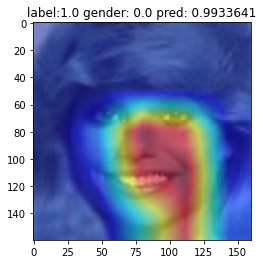

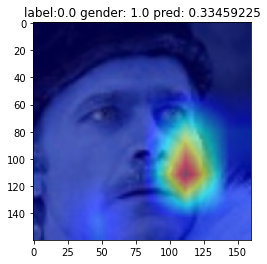

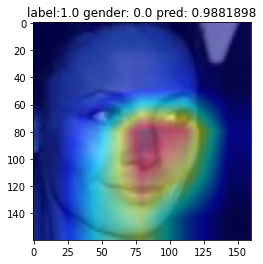

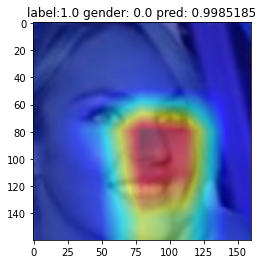

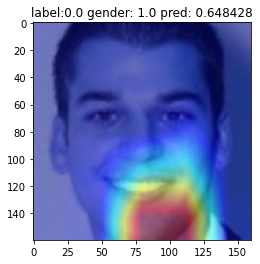

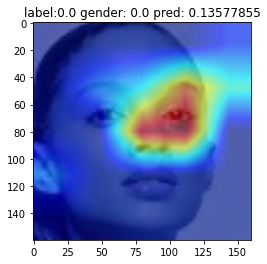

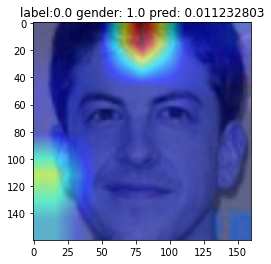

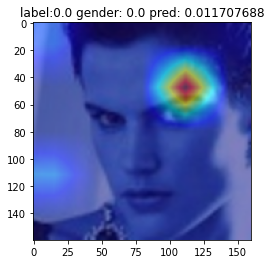

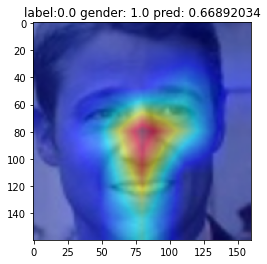

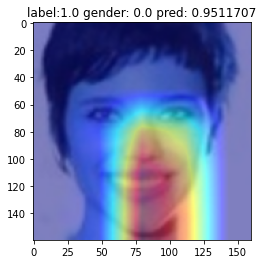

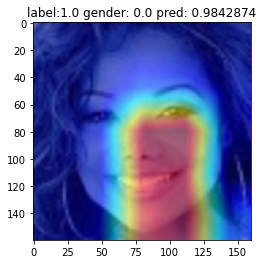

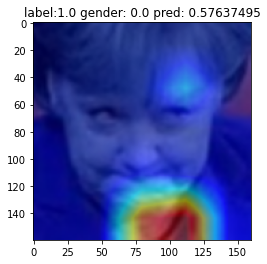

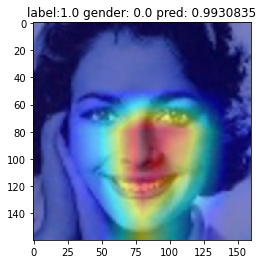

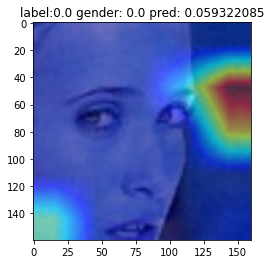

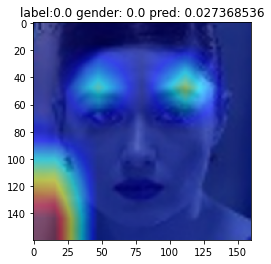

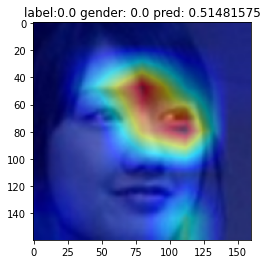

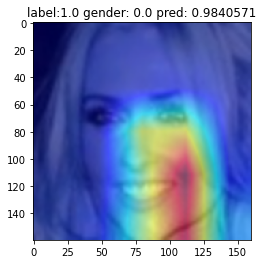

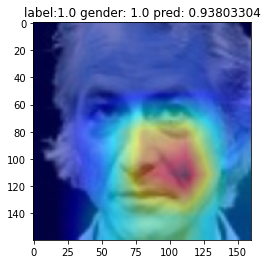

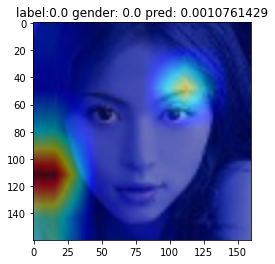

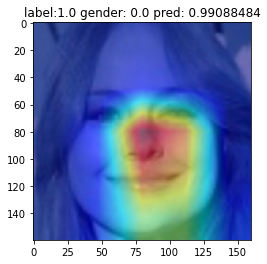

In [ ]:
for i in range(20):
    show_cam(i)

## Senet50

In [ ]:
val_transformations = transforms.Compose([transforms.Resize(size=224),
                                     transforms.ToTensor(),
                                     lambda x: x * 255.0,
                                     transforms.Normalize([131.0912, 103.8827, 91.4953], [1, 1, 1])
])

val_dataset = IdemiaDataset(dataframe=val_df, root_dir='validation/', transform=val_transformations)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4)

test_dataset = IdemiaDataset(dataframe=test_df, root_dir='test/', transform=val_transformations)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4)
model = senet50_ft_dag()
model.classifier = nn.Sequential(nn.Linear(2048, 1))
model.to(device)
model.load_state_dict(torch.load('models/senet50ft_dag_224.pth'))

<All keys matched successfully>

In [ ]:
target_layer = model.conv5_3_relu
def show_cam(idx):
    plt.figure()
    input_tensor = torch.unsqueeze(val_dataset[idx][0], 0)# Create an input tensor image for your model..
    # Note: input_tensor can be a batch tensor with several images!
    preds = sigmoid(model(input_tensor.to(device))).cpu().detach().numpy()[0][0]
    # Construct the CAM object once, and then re-use it on many images:
    cam = GradCAM(model=model, target_layer=target_layer, use_cuda=True)

    target_category = 0

    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

    rgb_img = cv2.imread('validation/' + "{0:0>6}".format(idx) +'.jpg', 1)[:, :, ::-1]
    rgb_img = cv2.resize(rgb_img, (224,224))
    rgb_img = np.float32(rgb_img) / 255

    # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(rgb_img, grayscale_cam)
    visualization = cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB)

    plt.imshow(visualization)
    plt.title('label:' + str(val_dataset[idx][1]) + ' gender: ' + str(val_dataset[idx][2]) + ' pred: ' + str(preds));

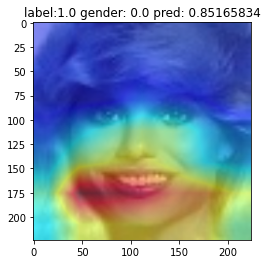

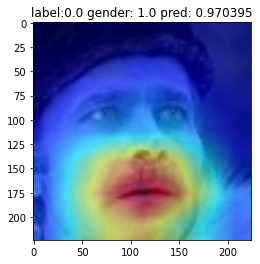

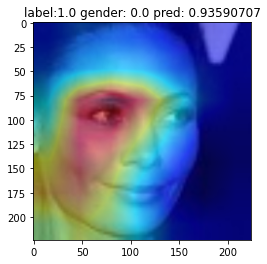

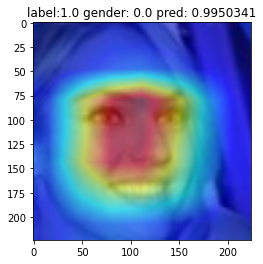

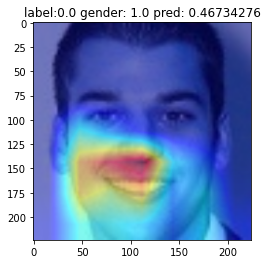

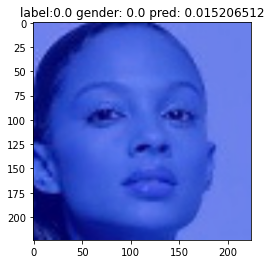

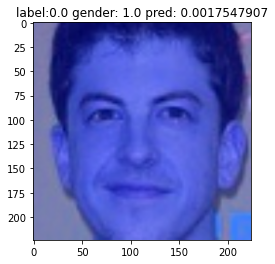

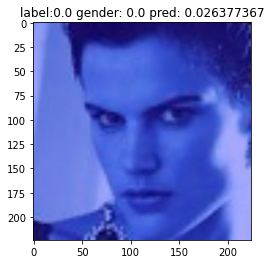

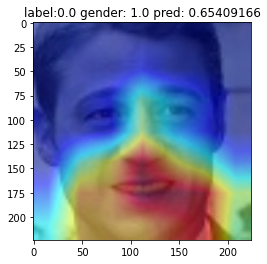

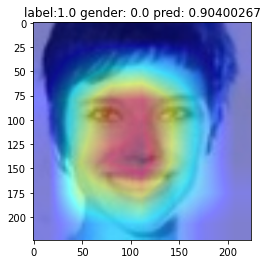

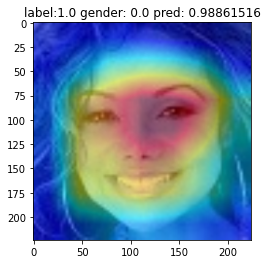

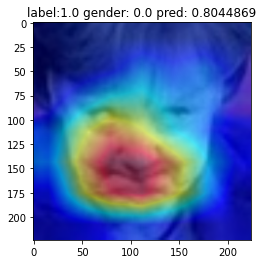

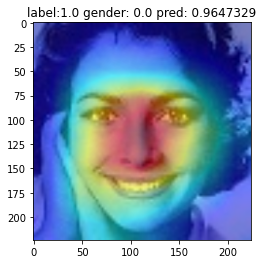

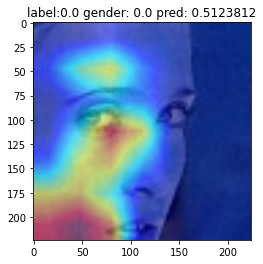

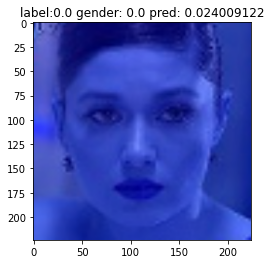

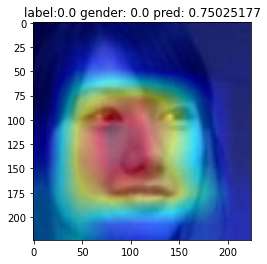

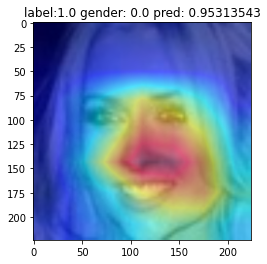

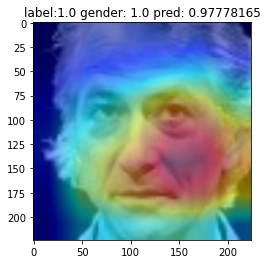

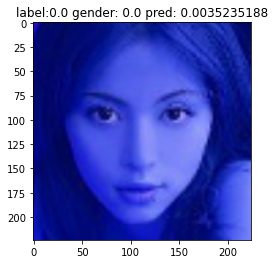

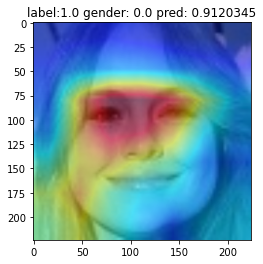

In [ ]:
for i in range(20):
    show_cam(i)